<a href="https://colab.research.google.com/github/gunjansa/schoolofai/blob/main/Modular_SchoolOfAISession_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import utils
import model_assignemnt_5 as model
import model_assignment_6 as model_6
import trainer

CODE BLOCK: 2

In [10]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

CUDA Available? True


device(type='cuda')

CODE BLOCK: 3

In [11]:
train_loader, test_loader = utils.create_mnist_dataloader(512)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


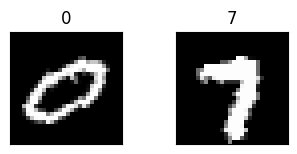

In [12]:
utils.get_dataset_images(train_loader, 2)

In [ ]:
model_mnist_6 = model_6.Net().to(device)
utils.get_model_summary(model_mnist_6, device)

In [10]:
model_mnist_5 = model.Net().to(device)
utils.get_model_summary(model_mnist_5, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [27]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.batchnorm6 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batchnorm7 = nn.BatchNorm2d(32)
        # self.conv8 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # self.batchnorm8 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.1)

        # CONV and GAP
        self.conv9 = nn.Conv2d(32, 10, kernel_size=1)

        # GAP and FC1
        self.average_pooling =  nn.AvgPool2d(3)
        self.fc1 = nn.Linear(32, 10)
        # self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.dropout(self.pool1(self.batchnorm2(F.relu(self.conv2(self.batchnorm1(F.relu(self.conv1(x))))))))
        x = self.dropout(self.pool2(self.batchnorm4(F.relu(self.conv4(self.batchnorm3(F.relu(self.conv3(x))))))))
        x = self.dropout(self.pool3(self.batchnorm6(F.relu(self.conv6(self.batchnorm5(F.relu(self.conv5(x))))))))
        x = self.dropout(self.batchnorm7(F.relu(self.conv7(x))))

        x = F.relu(self.conv9(x))

        x = F.relu(self.average_pooling(x))
        x = x.view(len(x), 10)
        # x = self.fc1(x)

        return F.log_softmax(x, dim=1)

In [28]:
model_mnist_test = Net().to(device)
utils.get_model_summary(model_mnist_test, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3            [-1, 8, 28, 28]             296
       BatchNorm2d-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
           Dropout-6            [-1, 8, 14, 14]               0
            Conv2d-7            [-1, 8, 14, 14]             584
       BatchNorm2d-8            [-1, 8, 14, 14]              16
            Conv2d-9           [-1, 16, 14, 14]           1,168
      BatchNorm2d-10           [-1, 16, 14, 14]              32
        MaxPool2d-11             [-1, 16, 7, 7]               0
          Dropout-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 16, 7, 7]           2,320
      BatchNorm2d-14             [-1, 1

In [29]:
model_mnist_test = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
optimizer = optim.SGD(model_mnist_test.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  trainer.train(model_mnist_test, device, train_loader, optimizer, criterion)
  trainer.test(model_mnist_test, device, test_loader, criterion)
  scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


  0%|          | 0/118 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train: Loss=0.1178 Batch_id=117 Accuracy=84.18:  98%|█████████▊| 116/118 [00:19<00:00,  5.61it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train: Loss=0.1178 Batch_id=117 Accuracy=84.18: 100%|██████████| 118/118 [00:19<00:00,  6.18it/s]


Test set: Average loss: 0.0002, Accuracy: 9769/10000 (97.69%)

Epoch 2


Train: Loss=0.0379 Batch_id=117 Accuracy=96.65: 100%|██████████| 118/118 [00:17<00:00,  6.58it/s]


Test set: Average loss: 0.0001, Accuracy: 9872/10000 (98.72%)



In [ ]:
model_mnist = model.Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
optimizer = optim.SGD(model_mnist.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  trainer.train(model_mnist, device, train_loader, optimizer, criterion)
  trainer.test(model_mnist, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.2560 Batch_id=117 Accuracy=49.49: 100%|██████████| 118/118 [00:22<00:00,  5.14it/s]


Test set: Average loss: 0.0006, Accuracy: 9159/10000 (91.59%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0880 Batch_id=117 Accuracy=93.31: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


Test set: Average loss: 0.0002, Accuracy: 9713/10000 (97.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0771 Batch_id=117 Accuracy=96.27: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0002, Accuracy: 9791/10000 (97.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0953 Batch_id=117 Accuracy=96.97: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


Test set: Average loss: 0.0001, Accuracy: 9845/10000 (98.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0455 Batch_id=117 Accuracy=97.49: 100%|██████████| 118/118 [00:21<00:00,  5.37it/s]


Test set: Average loss: 0.0001, Accuracy: 9860/10000 (98.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0287 Batch_id=117 Accuracy=97.84: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


Test set: Average loss: 0.0001, Accuracy: 9879/10000 (98.79%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0347 Batch_id=117 Accuracy=98.08: 100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


Test set: Average loss: 0.0001, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1607 Batch_id=117 Accuracy=98.17: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.0001, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1283 Batch_id=117 Accuracy=98.30: 100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


Test set: Average loss: 0.0001, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0233 Batch_id=117 Accuracy=98.43: 100%|██████████| 118/118 [00:23<00:00,  5.08it/s]


Test set: Average loss: 0.0001, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0591 Batch_id=117 Accuracy=98.50: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.0001, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0508 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


Test set: Average loss: 0.0001, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0183 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


Test set: Average loss: 0.0001, Accuracy: 9918/10000 (99.18%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0038 Batch_id=117 Accuracy=98.81: 100%|██████████| 118/118 [00:22<00:00,  5.16it/s]


Test set: Average loss: 0.0001, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.1008 Batch_id=117 Accuracy=98.88: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Test set: Average loss: 0.0001, Accuracy: 9912/10000 (99.12%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0103 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:23<00:00,  4.94it/s]


Test set: Average loss: 0.0000, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0415 Batch_id=117 Accuracy=99.23: 100%|██████████| 118/118 [00:23<00:00,  5.03it/s]


Test set: Average loss: 0.0000, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0087 Batch_id=117 Accuracy=99.18: 100%|██████████| 118/118 [00:23<00:00,  5.04it/s]


Test set: Average loss: 0.0000, Accuracy: 9922/10000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0035 Batch_id=117 Accuracy=99.20: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Test set: Average loss: 0.0000, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0254 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:22<00:00,  5.28it/s]


Test set: Average loss: 0.0000, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-03.


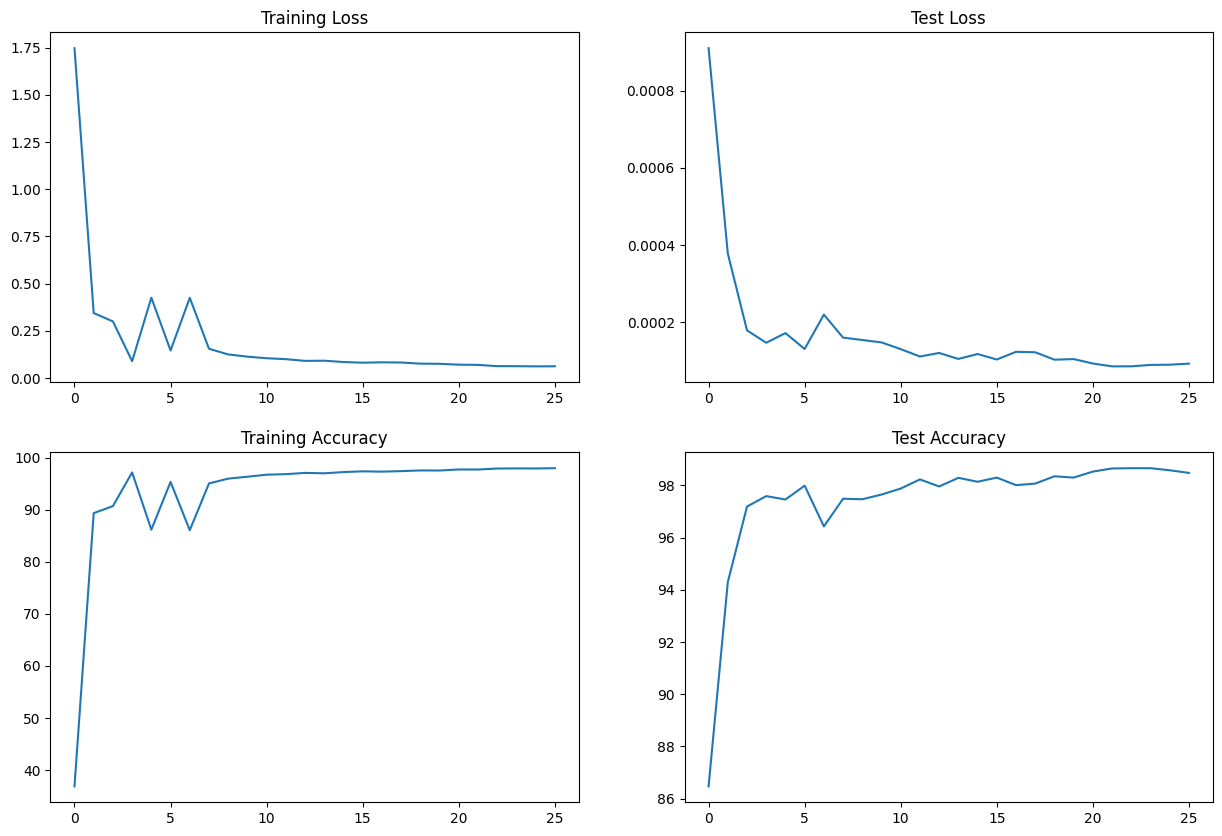

In [22]:
trainer.draw_graphs()

In [ ]:
utils.get_model_summary(model_mnist, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [ ]:
t = torch.tensor(
    [[[1,1,0,2],
    [0,3,3,0],
    [4,0,2,5]],
    [[4,0,3,1],
    [0,7,7,0],
    [1,0,6,2]]])
t

tensor([[[1, 1, 0, 2],
         [0, 3, 3, 0],
         [4, 0, 2, 5]],

        [[4, 0, 3, 1],
         [0, 7, 7, 0],
         [1, 0, 6, 2]]])

In [ ]:
t.max(dim=2)

torch.return_types.max(
values=tensor([[2, 3, 5],
        [4, 7, 6]]),
indices=tensor([[3, 1, 3],
        [0, 1, 2]]))

In [ ]:
tt = torch.tensor([[1, 0, 0, 2], [0,3,3,0]]) # [x1, y1, z1, v1], [x2, y2, z2, v2]
tt

tensor([[1, 0, 0, 2],
        [0, 3, 3, 0]])

In [ ]:
tt.max(dim=0)

torch.return_types.max(
values=tensor([1, 3, 3, 2]),
indices=tensor([0, 1, 1, 0]))